In [9]:
from UniDec import unidec
import matplotlib.pyplot as plt
import numpy as np

# mass_range = [11500.0, 13000.0]
# load text file
eng = unidec.UniDec()
eng.open_file("mean_data.txt")

eng.process_data()
eng.run_unidec()
eng.pick_peaks()
eng.process_mass_data()

mass_dist_data = np.loadtxt("mean_data_unidecfiles/mean_data_mass.txt")




UniDec Engine v.4.4.0

UniDec Path: c:\Users\cm19ljc\Documents\GitHub\MS-Analysis\UniDec\unidec_bin\UniDec.exe
Opening File:  mean_data.txt
Loading Time: 6s
Linear False
Data Prep Time: 0.97s
UniDec run 16s
File Name:  mean_data.txt R Squared:  0.10047350350251727


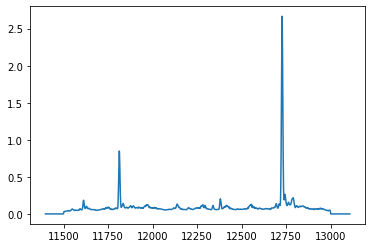

In [10]:
dist_data = mass_dist_data.T

plt.plot(dist_data[0], dist_data[1])
plt.show()